## 1. 데이터 셋업
-----

### 모듈 임포트

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 필요한 변수 생성

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기
-----

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### train과 val에 있는 데이터 모아 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 정상이미지와 폐렴이미지의 개수 확인

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [7]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


### tf.data 인스턴스 생성

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### Train 데이터셋, validation 데이터셋 개수 확인

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨데이터 생성하는 함수

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지데이터 사이즈 축소

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### train 셋과 validation 셋 생성

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 리사이즈 및 라벨링 결과 확인

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test 데이터 셋 생성

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

* ```prepare_for_training()```: 학습데이터를 효율적인 형태로 변환
* ```shuffle()```: 고정 크기 버퍼 유지 및 해당 버퍼에서 무작위로 균일하게 다음요소 선택
* ```repeat()```: epoch 진행시 데이터셋을 여러번 사용가능하게 하는 옵션
* ```batch()```: BATCH_SIZE에서 정한 만큼의 배치로 주어짐
* ```prefetch()```: 학습데이터를 나누어서 읽음, GPU가 첫번째 데이터 학습하는 동안 두번 째 데이터를 CPU에서 준비하여 리소스의 유휴상태 줄임

## 3. 데이터 시각화
-----

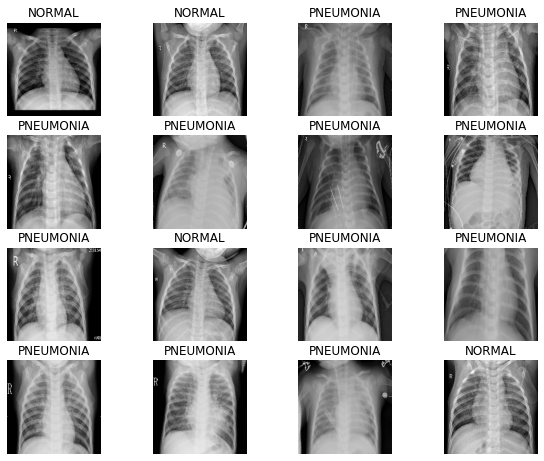

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링
-----

### CNN 블록

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense 블록

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 모델 생성

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
-----

* imbalance: 라벨 중에서 특정 라벨이 너무 많은 경우, 학습효과가 떨어진다.




### Weight balancing

* training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖게 가중치를 부여하는 방법
* Keras는 model.fit() 호출시 class_weight 파라미터를 활용해 클래스별 가중치를 세팅할 수 있게 지원 

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
-----

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 139ms/step - loss: 0.5655 - accuracy: 0.6981 - precision: 0.8985 - recall: 0.6685 - val_loss: 0.7246 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2246 - accuracy: 0.9098 - precision: 0.9673 - recall: 0.9097 - val_loss: 1.0564 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2222 - accuracy: 0.9171 - precision: 0.9740 - recall: 0.9131 - val_loss: 0.2133 - val_accuracy: 0.9048 - val_precision: 0.8852 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1594 - accuracy: 0.9377 - precision: 0.9795 - recall: 0.9358 - val_loss: 0.1061 - val_accuracy: 0.9654 - val_precision: 0.9596 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1736 - accura

## 7. 결과확인
-----

### Epochs 마다 모델의 precision, recall, accuracy, loss 시각화

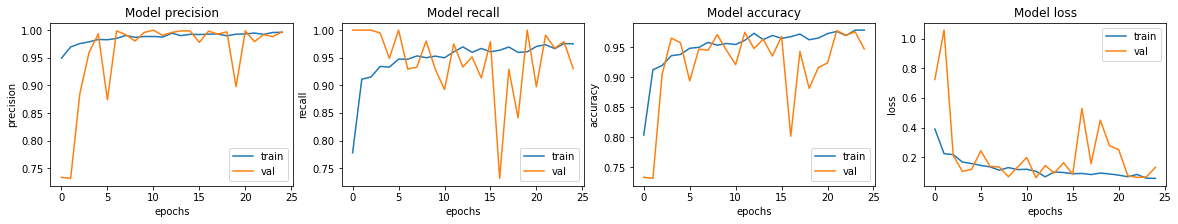

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 테스트 데이터로 모델 평가

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 77ms/step - loss: 0.5910 - accuracy: 0.8622 - precision: 0.8439 - recall: 0.9564
Loss: 0.5909616351127625,
Accuracy: 0.8621794581413269,
Precision: 0.8438913822174072,
Recall: 0.9564102292060852


* 의사의 진단률이 90%이상, 좀 더 개선이 필요하다.

## 8. 폐렴진단기 성능개선
-----

### 각 스텝별 개선 point

#### 1. 데이터 셋업
* batch size
* epoch
#### 2. 데이터 준비
* Data augmentation
> -데이터를 구하기 어렵고, 소량의 데이터만 구해지는 경우 시도   
  -각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많다.   
  -기본적인 Data augmentation 방법들이 의료 분야에서 많이 사용된다. ex) 이미지회전, 이미지 좌우반전, 가우시안 노이즈 추가
  
#### 3. 데이터 시각화
* 2.에서 argumentation 시 결과확인

#### 4. CNN 모델링
* Convolution filter
* 채널 개수
* activation,
* 모델 구조
> 현재 BatchNomalization과 Dropout이 결합된 특이한 구성이므로 아래의 시도를 해본다,   
  -BatchNomalization 만   
  -Droupout만   
  -Droupout의 비율 변경
  

#### 5. 데이터 imbalance 처리
* class_weight 설정 생략
* recall 강조 위해 폐렴 데이터 잘 맞추는 것을 더 강화하는 효과 가능할까?

#### 6. 모델 훈련
* optimizer
* learning rate

#### 7. 결과 확인과 시각화
* accuracy
* recall
* history 그래프 시각화 후 학습진행 양상 분석

### 루비콘 평가기준
> **1. 의료영상을 처리하는 CNN기반 딥러닝 모델이 잘 구현 되었다.**   
  -모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.   
  **2. 데이터 준비, 모델구성 등 과정의 다양한 실험이 체계적으로 수행되었다.**   
  -regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.   
  **3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**
  -Accuracy 기준 85%에 도달하였다.

### 개선 우선 순위 수립

#### 5.데이터 imbalance 처리 -> 4.CNN 모델링 -> 6.모델 훈련 & 1.의 batch_size와 epoch

* 먼저 imbalance 처리 유/무의 차이를 본다. 
* CNN 모델을 개선한다.
* 모델 훈련 과정의 파라미터를 조절한다.

### 데이터 imbalance 미처리시

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 40s 130ms/step - loss: 0.0466 - accuracy: 0.9856 - precision: 0.9935 - recall: 0.9871 - val_loss: 0.0572 - val_accuracy: 0.9788 - val_precision: 0.9933 - val_recall: 0.9777
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.0309 - accuracy: 0.9907 - precision: 0.9952 - recall: 0.9923 - val_loss: 0.0609 - val_accuracy: 0.9779 - val_precision: 0.9856 - val_recall: 0.9843
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.0410 - accuracy: 0.9883 - precision: 0.9945 - recall: 0.9897 - val_loss: 0.0703 - val_accuracy: 0.9798 - val_precision: 0.9830 - val_recall: 0.9895
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.0305 - accuracy: 0.9914 - precision: 0.9952 - recall: 0.9932 - val_loss: 0.0758 - val_accuracy: 0.9788 - val_precision: 0.9830 - val_recall: 0.9882
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.0444 - accura

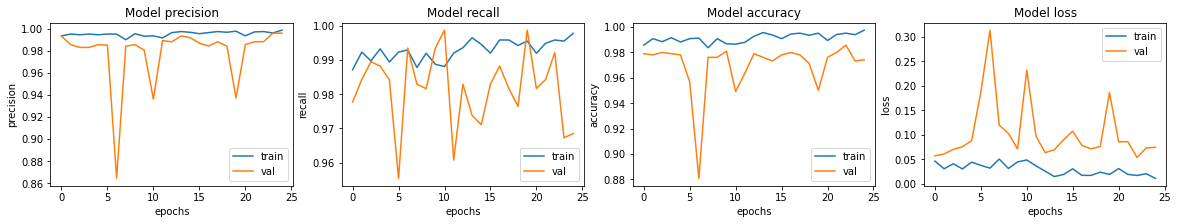

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.6054 - accuracy: 0.7997 - precision: 0.7645 - recall: 0.9821
Loss: 1.6053677797317505,
Accuracy: 0.7996794581413269,
Precision: 0.7644710540771484,
Recall: 0.9820512533187866


> 오히려 정확도가 떨어졌다. 데이터 imbalance 처리는 필요하다. 하지만 recall이 98%로 더 높아졌다! 

### CNN모델 개선

####  모델 구조 변경 - 1. BatchNomalization만 적용

In [29]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [30]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [32]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 132ms/step - loss: 0.3178 - accuracy: 0.8425 - precision: 0.9678 - recall: 0.8156 - val_loss: 0.6690 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1781 - accuracy: 0.9339 - precision: 0.9797 - recall: 0.9305 - val_loss: 1.1825 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1286 - accuracy: 0.9497 - precision: 0.9858 - recall: 0.9464 - val_loss: 0.7564 - val_accuracy: 0.7385 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1294 - accuracy: 0.9467 - precision: 0.9847 - recall: 0.9419 - val_loss: 0.0762 - val_accuracy: 0.9702 - val_precision: 0.9906 - val_recall: 0.9686
Epoch 5/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1084 - accura

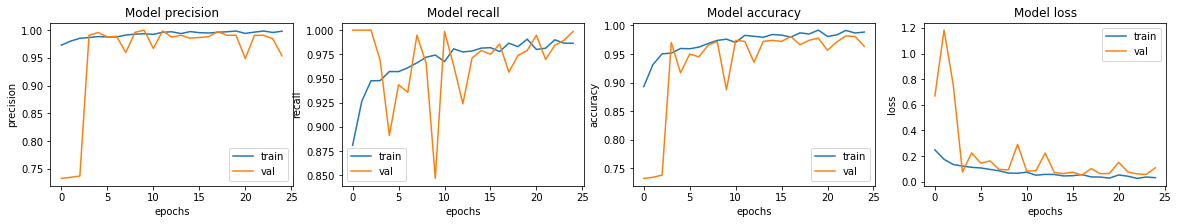

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 1.5934 - accuracy: 0.7147 - precision: 0.6866 - recall: 1.0000
Loss: 1.5934152603149414,
Accuracy: 0.7147436141967773,
Precision: 0.6866196990013123,
Recall: 1.0


> 테스트 데이터에서의 정확도가 95%가 넘으면서 오버피팅이 발생했다. recall이 100%에 도달했다.

####  모델 구조 변경 - 2. Dropout만 적용

* learning late를 키우기 위해 BATCH_SIZE를 늘리고 오버피팅을 막기 위해 EPOCHS를 줄였다.

In [37]:
BATCH_SIZE = 32
EPOCHS = 15

In [38]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [39]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [40]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )    

Epoch 1/15
130/130 [==============================] - 26s 150ms/step - loss: 0.6758 - accuracy: 0.6860 - precision: 0.7547 - recall: 0.8623 - val_loss: 0.6859 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 19s 148ms/step - loss: 0.7112 - accuracy: 0.4732 - precision: 0.7555 - recall: 0.4014 - val_loss: 0.6869 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 19s 145ms/step - loss: 0.6885 - accuracy: 0.6282 - precision: 0.7542 - recall: 0.7479 - val_loss: 0.6956 - val_accuracy: 0.2734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
130/130 [==============================] - 19s 146ms/step - loss: 0.6837 - accuracy: 0.5261 - precision: 0.7556 - recall: 0.5527 - val_loss: 0.7023 - val_accuracy: 0.2715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
130/130 [==============================] - 19s 145ms/step - loss:

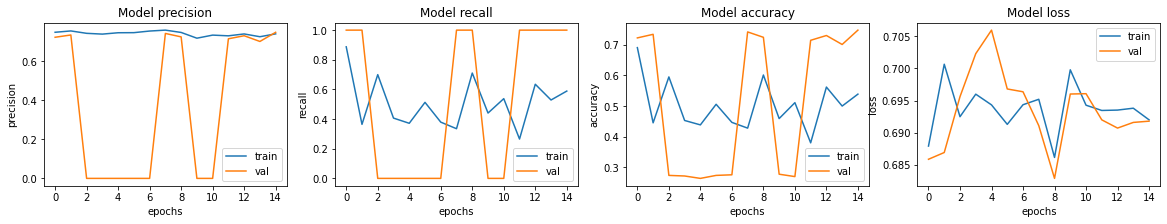

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.6925 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6924688816070557,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


####  모델 구조 변경 - 3. Dropout 비율 변경
* BatchNomalization과 Droupout 모두 적용후 비율을 변경해 준다.

In [43]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [44]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [45]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.9),
        dense_block(128, 0.7),
        dense_block(64, 0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [47]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )    

Epoch 1/15
130/130 [==============================] - 28s 155ms/step - loss: 0.9605 - accuracy: 0.4943 - precision: 0.7477 - recall: 0.4799 - val_loss: 0.7816 - val_accuracy: 0.2422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
130/130 [==============================] - 19s 150ms/step - loss: 0.6836 - accuracy: 0.6131 - precision: 0.8310 - recall: 0.5813 - val_loss: 0.8314 - val_accuracy: 0.2715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
130/130 [==============================] - 19s 149ms/step - loss: 0.7116 - accuracy: 0.6112 - precision: 0.8496 - recall: 0.5947 - val_loss: 0.5969 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 19s 149ms/step - loss: 0.5341 - accuracy: 0.7027 - precision: 0.9057 - recall: 0.6620 - val_loss: 0.6877 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 19s 149ms/step - loss:

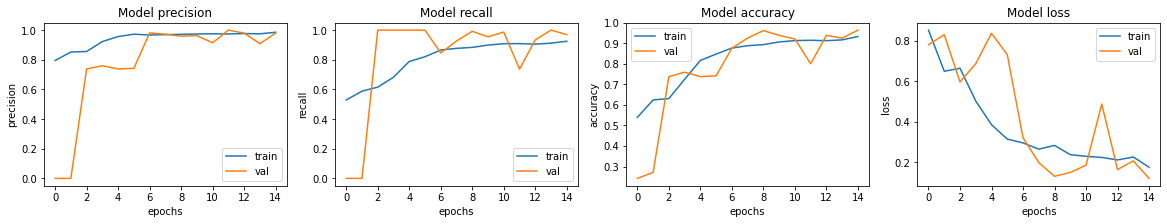

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [49]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.4943 - accuracy: 0.7885 - precision: 0.7580 - recall: 0.9718
Loss: 0.49430274963378906,
Accuracy: 0.7884615659713745,
Precision: 0.7580000162124634,
Recall: 0.971794843673706


## 9. 후기
-----

이번 노드에서 어려웠던 점은 개선책을 고민하는 부분과 정확도 조건을 충족시키는 것이었다. 